In [1]:
using JuMP
using Ipopt
using DataFrames
import XLSX

abstract type Model end
struct Direct <: Model end
struct Migration <: Model end

In [2]:
#run = Direct();
run = Migration();

#These two are interdependent in the model and can be included in the future
#a1 = 1/3.4e7 # proportion of migrating squid, where 3.4E7 max(e^(tau-b1))
#K = 1208770.0 # carrying capacity in t
# If you clamp l1, l2, the values of E will be pushed higher.
# These are the only real constants
f = 40.0 # l of fuel per trip
B_h = 7.203 # hours per fisher
B_f = 2.0 # fisher per panga
m = 5492603.58 # cost per unit of transport all boats, MXN/trip
c_t = m*f # fleet cost of transport

### Initial values #############################################################
#Currently not in use
tau0 = 42.0 # temperature
q0 = 0.01 # squid catchability
y_S0 = 0.5 # proportion of migrated squid
R_tt0 = 0.5 # trader cooperation
S0 = 1208770.0 # size of the squid population
E0 = 1.0 # fishing effort
C0 = 120877.0 # squid catch
p_e0 = 164706.0 # max p_e comtrade
p_f0 = 15438.0 # max p_f datamares
R0 = C0*p_f0-(c_t+E0);

In [3]:
#df2 looks at 2001-2016, so df1 should only yield that set too
df1 = DataFrame(XLSX.readtable("./DATA/R3_data.xlsx", "Sheet1")...)
# load columns
y = Int64.(df1[:year][11:26]) #
#pe = Float64.(map(x->ismissing(x) ? NaN : x, df1[:pe_MXNiat][11:26])) #
pf = Float64.(df1[:pf_MXNiat][11:26]) #
#ct = Float64.(map(x->ismissing(x) ? NaN : x, df1[:C_t][11:26])) #
#ssh = Float64.(map(x->ismissing(x) ? NaN : x, df1[:essh_avg][11:26])) #
ml = Float64.(df1[:ML][11:26]) #
ys = map(x->parse(Float64,x),df1[:y_S][11:26]) #


df2 = dropmissing(DataFrame(XLSX.readtable("./DATA/PriceVolDataCorrected.xlsx", "Sheet1")...))
VolAll = Float64.(df2[:tons_DM]) ## CATCH DATA
PrAll = Float64.(df2[:priceMXNia_DM]) ## PRICE DATA 

### New max time
tmax = length(df2[:Year]);

In [4]:
model = JuMP.Model(solver = IpoptSolver(max_iter=1000,print_frequency_iter=500,sb="yes"));

In [5]:
@variable(model, b1, start=41.750) # isotherm depth (est)
@variable(model, b2, start=-5.696) # isotherm depth (est)
@variable(model, b3, start=16.397) # isotherm depth (est)
@variable(model, 0.0 <= beta <= 1.0) # slope of demand-price function
@variable(model, 1000.0 <= c_p <= 2148.0) # cost of processing, MXNia/t
@variable(model, 0.0 <= g <= 3.2) # population growth rate
@variable(model, 20000.0 <= gamma <= 51000.0) # maximum demand, t
#@variable(model, h1) # E scale
#@variable(model, h2) # E scale
@variable(model, l1, start = -0.0028) # q scale
@variable(model, l2, start = 0.1667) # q scale
#testing
@variable(model, a1, start=1/3.4e7)
@variable(model, K, start=1208770.0)

@variable(model, 20.0 <= tau[t=1:tmax] <= 80.0) # temperature
@variable(model, 4000.0 <= p_e[t=1:tmax] <= 100_000.0) # export price
@variable(model, q[t=1:tmax]) # catchability squid population
@variable(model, 0.0 <= y_S[t=1:tmax] <= 1.0) # Proportion of squid migration from initial fishing grounds
# c_t is per trip so we need to upscale E hr > fisher > trip
#@variable(model, Escal[t=1:tmax]) # fishing effort
@variable(model, 0.0 <= E[t=1:tmax] <= 1.0) # fishing effort
@variable(model, S[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(model, C[t=1:tmax]  >= 0.0) # squid catch 10% of S
@variable(model, p_f[t=1:tmax]) # price for fishers
@variable(model, match)

if typeof(run) == Migration
    @variable(model, 11_956_952.0 <= w_m <= 28_108_539.0) # min wage per hour all fleet
    @variable(model, 0.0 <= R_tt[t=1:tmax] <= 1.0) # trader cooperation
    @variable(model, p_min[t=1:tmax] >= 0.0) # minimum wage 28_000_000 NOTE: This is quite low it seems
end

@constraint(model, [t=1:tmax], tau[t] == b1+b2*cos.(t)+b3*sin.(t));
@NLconstraint(model, [t=1:tmax], p_e[t] == gamma*(C[t])^(-beta));
#@NLconstraint(model, [t=1:tmax-1], Escal[t+1] == E[t]+p_f[t]*C[t]-c_t*(E[t]/(B_h+B_f)));
#@constraint(model, [t=1:tmax], E[t] == h1*Escal[t]+h2);
@NLconstraint(model, [t=1:tmax-1], S[t+1] == S[t]+g*S[t]*(1-(S[t]/K))-C[t]);
@NLconstraint(model, [t=1:tmax], C[t] == q[t]*E[t]*S[t]);
@NLconstraint(model, [t=1:tmax], y_S[t] == a1*exp(tau[t]-b1));
@NLconstraint(model, [t=1:tmax], q[t] == l1*tau[t]+l2);
if typeof(run) == Direct
    #First Model
    @constraint(model, [t=1:tmax], p_f[t] == p_e[t]-c_p);
else
    #Second model
    @NLconstraint(model, [t=1:tmax], p_min[t] == (E[t]*w_m)/C[t]);
    @constraint(model, [t=1:tmax], R_tt[t] == 1-y_S[t]);
    @constraint(model, [t=1:tmax], p_f[t] == (p_e[t]-c_p)*(1-R_tt[t])+R_tt[t]*p_min[t]);
end

#@constraint(model, C[1] == VolAll[1]); # squid catch
#@constraint(model, p_f[1] == PrAll[1]); # max p_f datamares
# Initial conditions
#@constraint(model, tau[1] == tau0);  # temperature
#@constraint(model, p_e[1] == p_e0); # max p_e comtrade

#@constraint(model, R_tt[1] == R_tt0); # trader cooperation
#@constraint(model, q[1] == q0); # squid catchability
#@constraint(model, E[1] == E0); # fishing effort
#@constraint(model, S[1] == S0); # size of the squid population

#Minimise the Least Squares differences between our model and the data
@NLconstraint(model, match == sum(abs(p_f[t] - PrAll[t])^2+abs(C[t] - VolAll[t])^2 for t in 1:tmax));
@objective(model, Min, match);

In [6]:
solve(model)

:Error

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      668
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      602

Total number of variables............................:      173
                     variables with only lower bounds:       48
                variables with lower and upper bounds:       85
                     variables with only upper bounds:        0
Total number of equality constraints.................:      144
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

**TODO:** `ML` and `R` have been removed from the model but ultimately are required outputs.
They should be post-processed vectors.

In [7]:
using Plots

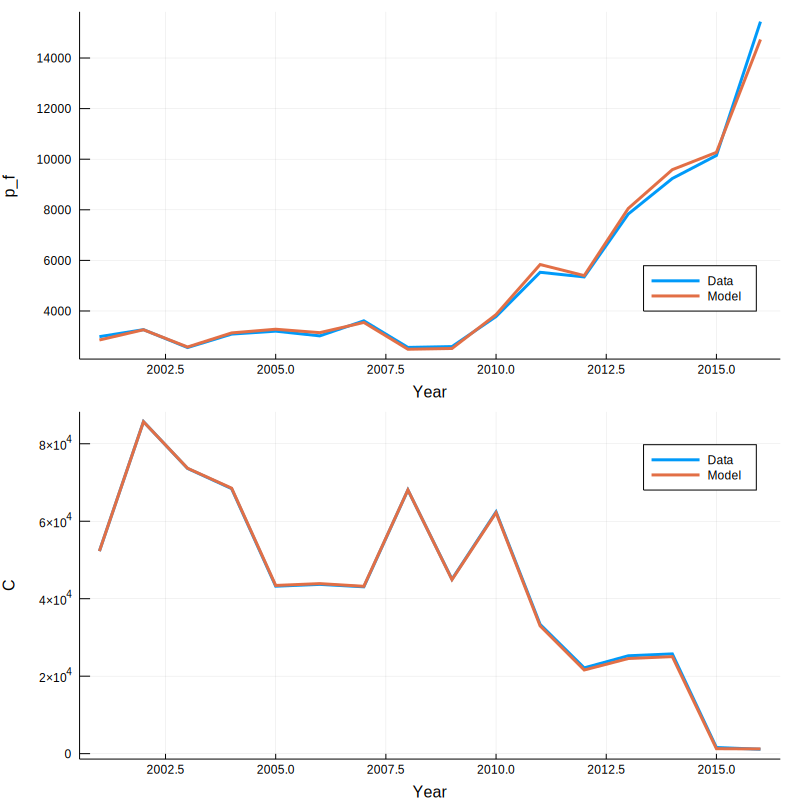

In [24]:
ha = plot(y, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:bottomright)
plot!(y, getvalue(p_f), label="Model")
hb = plot(y, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(y, getvalue(C), label="Model")
plot(ha,hb,linewidth=3,layout=(2,1),size=(800,800))

In [25]:
savefig("migration.png")

In [ ]:
using LsqFit
using Plots

In [ ]:
modpf(t,p) = p[1]*t.^(-p[2])-p[3]

In [ ]:
xdata = 1:16
p0 = [30000.0, 0.1, 1500.0]

In [ ]:
fit = curve_fit(modpf, VolAll, PrAll, p0)

In [ ]:
plot(PrAll)
plot!(modpf(VolAll,fit.param))

In [ ]:
fit.param